In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tabulate import tabulate
import seaborn as sns
from datetime import datetime
import random

Los siguientes datasets han sido analizados individualmente en los archivos: 'eda_movies.ipynb' y 'eda_ratings.ipynb'.

Se recomienda ver primero esos analisis individuales para entender la naturaleza de los datos.

In [2]:
# Carga de datos peliculas
df_movies = pd.read_csv('../raw/ml-20m/movies.csv')

In [3]:
# Carga de datos valoraciones
df_ratings= pd.read_csv('../raw/ml-20m/train_ratings.csv')
df_ratings.drop('Unnamed: 0', axis =1, inplace=True)

Analisis global compuesto del conjunto de datos pelicula y valoraciones

In [6]:
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [7]:
df_ratings

,userId,movieId,rating,timestamp
0,4276,6537,2.0,1166745600
1,106451,1252,5.0,938856724
2,110359,4896,4.0,1026736453
3,55651,5292,4.0,1339373664
4,107640,813,2.0,1082740213
...,...,...,...,...
18000231,131630,1672,4.0,1081218783
18000232,7547,3039,3.5,1121665512
18000233,9738,7445,3.0,1095175492
18000234,16826,4239,5.0,1039451088


In [11]:
# Numero de peliculas unicas en ambos dataset
n_dfMovies = df_movies['movieId'].nunique()
n_dfRating = df_ratings['movieId'].nunique()

print('Numero de peliculas en df_movies:',n_dfMovies)
print('Numero de peliculas en df_ratings:',n_dfRating)
print('Diferencia en el numero de peliculas entre los datasets:',n_dfMovies-n_dfRating)

Numero de peliculas en df_movies: 27278
Numero de peliculas en df_ratings: 26349
Diferencia en el numero de peliculas entre los datasets: 929


Como podemos observar, el dataset de peliculas (df_movies) cuenta con 929 peliculas extras que no han sido valoradas en el dataset de valoraciones (df_rating).

In [4]:
# Merge de los datasets a traves del movieId
df_combined = df_ratings.merge(df_movies, how='right', on='movieId')

In [5]:
df_combined.head()

,userId,movieId,rating,timestamp,title,genres
0,64194.0,1,3.0,8.915850e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1584.0,1,5.0,9.747302e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,77747.0,1,5.0,9.913688e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,17977.0,1,3.0,1.167735e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,18200.0,1,3.5,1.208818e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [30]:
# Numero de peliculas tras combinar los datasets (Si no existe valoraciones para x pelicula se rellenaran los valores con NaN)
n_movies = df_combined['movieId'].nunique()
n_users = df_combined['userId'].nunique()
print('Numero de peliculas en df_combined:',n_movies)
print('Numero de usuarios en df_combined:',n_users)

Numero de peliculas en df_combined: 27278
Numero de usuarios en df_combined: 138493


In [116]:
# Comprobamos que los usuarios no hayan valorado mas de una vez la misma pelicula
# Agrupar por userId y movieId, y contar la frecuencia de cada combinación
user_movie_count = df_combined.groupby(['userId', 'movieId']).size().reset_index(name='count')
# Filtrar las filas donde el recuento es mayor que 1 (usuario ha visto la película más de una vez)
users_rewatched_movies = user_movie_count[user_movie_count['count'] > 1]
# Imprimir el resultado
print(users_rewatched_movies)

Empty DataFrame
Columns: [userId, movieId, count]
Index: []


No hay presencia de que los usuarios hayan valorado mas de una vez las mismas peliculas

In [6]:
# Convertir 'userId' a int
df_combined['userId'] = pd.to_numeric(df_combined['userId'], errors='coerce').astype('Int64')

# Convertir 'timestamp' a int
df_combined['timestamp'] = pd.to_numeric(df_combined['timestamp'], errors='coerce').astype('Int64')

In [7]:
# Grafico de peliculas valoradas y no valoradas por los 3 generos mas frecuentes
def plot_valoratedMovies(count_by_genre):
    # Normalizar los datos
    count_by_genre_normalized = count_by_genre.div(count_by_genre.sum(axis=1), axis=0) * 100

    # Graficar barras apiladas
    plt.figure(figsize=(10, 6))
    ax = count_by_genre_normalized.plot(kind='bar', stacked=True, width=0.8, colormap='viridis')
    ax.set_yscale('log')
    ax.set_ylabel('Porcentaje de Películas')
    ax.set_xlabel('Género')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title('Porcentaje de Películas Valoradas y No Valoradas por Género')

    # Etiquetas personalizadas en la leyenda
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([label.replace('1', 'No').replace('0', 'Si') for label in reversed(labels)], title='Valorada', loc='upper right')

    plt.show()

In [8]:
# Logica que controla y agrupa los datos para la representacion grafica
def logic_valoratedMovies(value,df_combined=df_combined):
    # Agregar una columna 'valorada' que indica si una película fue valorada o no
    df_combined_copy = df_combined.copy()
    df_combined_copy['valorated']=df_combined_copy['rating'].notna()

    # Obtener los géneros más frecuentes
    top_genres = df_combined_copy['genres'].value_counts(normalize=True).nlargest(value).index

    # Filtrar el DataFrame para incluir solo las películas de los géneros más frecuentes
    df_filtered = df_combined_copy[df_combined_copy['genres'].isin(top_genres)]

    # Contar películas valoradas y no valoradas por género
    count_by_genre = df_filtered.groupby(['genres', 'valorated']).size().unstack(fill_value=0)

    # Reindexar para asegurarse de que todos los géneros estén presentes
    count_by_genre = count_by_genre.reindex(columns=[0, 1], fill_value=0)

    # Pintamos el resultado
    print('Tabla de diferencias sin normalizar\n' + '-'*40)
    print(tabulate(count_by_genre, headers=['Género', 'No Valorada', 'Valorada'], tablefmt='pretty'))

    print('\nGrafica Normalizada para ver diferencias entre valoradas y no valoradas\n' + '-'*40)
    # Llamada para graficar el resultado
    plot_valoratedMovies(count_by_genre)

Tabla de diferencias sin normalizar
----------------------------------------
+---------------------------+-------------+----------+
|          Género           | No Valorada | Valorada |
+---------------------------+-------------+----------+
|  Action|Adventure|Sci-Fi  |      2      |  396810  |
| Action|Adventure|Thriller |      0      |  282284  |
|   Action|Crime|Thriller   |      2      |  279453  |
|          Comedy           |     83      | 1185175  |
|       Comedy|Drama        |     39      |  591092  |
|   Comedy|Drama|Romance    |     20      |  554282  |
|      Comedy|Romance       |     26      |  714169  |
|        Crime|Drama        |     16      |  420383  |
|           Drama           |     166     | 1321235  |
|       Drama|Romance       |     46      |  580329  |
+---------------------------+-------------+----------+

Grafica Normalizada para ver diferencias entre valoradas y no valoradas
----------------------------------------


<Figure size 1000x600 with 0 Axes>

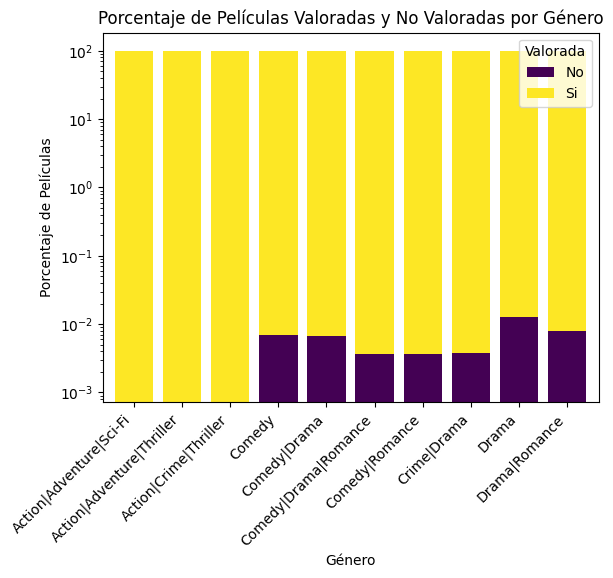

In [14]:
logic_valoratedMovies(value=10)

Como podemos observar la diferencia entre peliculas valoradas y no valoradas por genero es muy grande.

Algunos generos cuentan practicamente con todas las peliculas valoradas, por lo tanto no se llega a representar en el grafico.

*Fue necesario escalar logaritmicamente para poder mostrar las diferencias en el grafico*

In [101]:
# Analisis de reseñas por usuario seleccionado
def find_reviews_by_user(id):
    user_reviews = df_combined[df_combined['userId'] == id]
    user_reviews_count = user_reviews['rating'].count()
    user_reviews_mean = user_reviews['rating'].mean()
    if user_reviews_count == 0:
        print(f'El usuario con ID {id} no ha proporcionado ninguna reseña.')
    else:
        print(f'Número total de reseñas del usuario con ID {id}: {user_reviews_count}')
        print(f'Media de reseñas del usuario con ID {id}: {round(user_reviews_mean,1)} puntos')


In [124]:
find_reviews_by_user(id=109744)

Número total de reseñas del usuario con ID 109744: 1366
Media de reseñas del usuario con ID 109744: 3.6 puntos


In [54]:
# Convertimos variable timestamp a datetime
df_combined['timestamp'] = df_combined['timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d') if pd.notna(x) else np.nan)
df_combined['timestamp'] = df_combined['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d') if pd.notna(x) else np.nan)

In [80]:
# Funcion que pinta el grafico de lineas por usuarios y valoraciones medias
def plot_average_rating_per_user(avg_rating_per_user_over_time):
    
    # Graficar la media de valoraciones por usuario a lo largo del tiempo
    plt.figure(figsize=(12, 6))
    for user_id in avg_rating_per_user_over_time['userId'].unique():
        user_data = avg_rating_per_user_over_time[avg_rating_per_user_over_time['userId'] == user_id]
        
        # Línea de conexión entre los puntos
        plt.plot(user_data['timestamp'], user_data['rating'], label=f'Usuario {user_id}')
        
        # Puntos superpuestos en cada valoración
        plt.scatter(user_data['timestamp'], user_data['rating'], alpha=0.5)

    plt.title('Media de Calificaciones por Usuario a lo largo del Tiempo (Muestra Aleatoria)')
    plt.xlabel('Fecha')
    plt.ylabel('Media de Calificaciones')

    # Formato del eje x para mostrar solo el año y primer mes
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [77]:
# Logica de calificaciones media de usuarios segun temporalidad
def logic_average_rating_per_user(sample_size,df_combined=df_combined):
    df_combined_copy = df_combined.copy()

    # Obtener un muestreo aleatorio de usuarios
    random_users = random.sample(df_combined_copy['userId'].unique().tolist(), sample_size)

    # Filtrar el DataFrame solo para los usuarios de muestra
    df_sample = df_combined_copy[df_combined_copy['userId'].isin(random_users)]

    # Calcular la media de valoraciones por usuario y por período de tiempo
    avg_rating_per_user_over_time = df_sample.groupby(['userId', pd.Grouper(key='timestamp', freq='M')])['rating'].mean().reset_index()

    # Llamada a funcion que representa el grafico
    plot_average_rating_per_user(avg_rating_per_user_over_time)

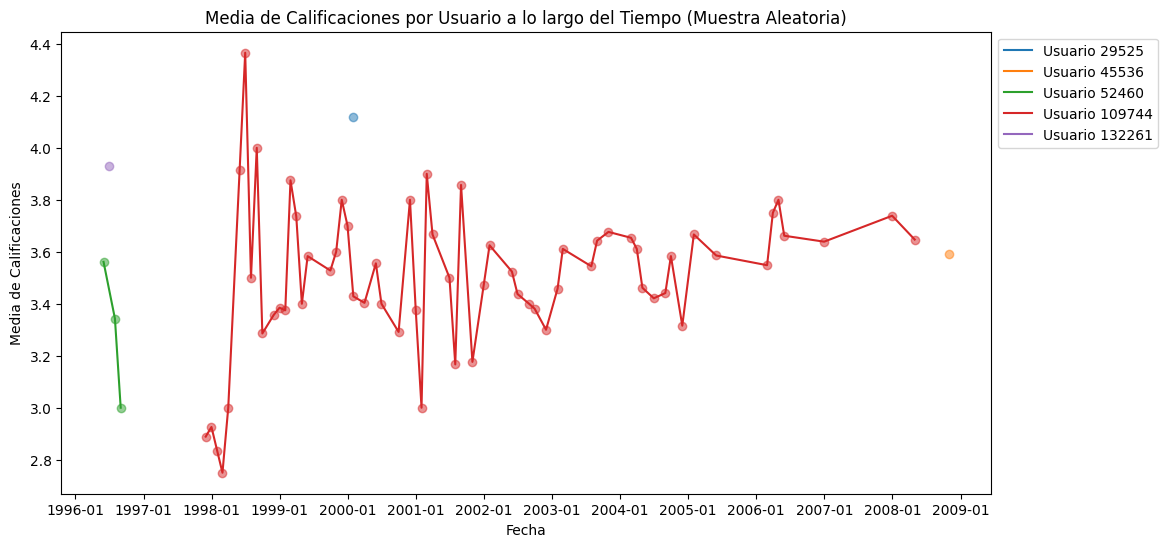

In [123]:
logic_average_rating_per_user(sample_size=5) # Ajustar cantidad de usuario a mostrar

En este grafico observamos la media mensual de valoraciones por cada usuario (los usuarios son escogidos aleatoriamente, debido a la gran cantidad de datos que disponemos).

Podemos observar usuarios que solo han valorado una vez algunas peliculas, y otros varias veces al año. Por tanto, estamos ante un conjunto de datos con usuarios cuya actividad es muy variada.

Podemos diferenciar los usuarios en dos grupos:

- Usuarios ocasionales: solo han valorado un numero x de peliculas en un momento concreto (mes).
- Usuarios frecuentes: han valorado un numero x de peliculas en diferentes momentos (meses).